# Analyze Methods
This notebook creates the summarizes and visuals for sentence-level target identification.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import os
import pickle
import warnings

## Below are all of the local imports

In [6]:
import sys
sys.path.append("..")

In [7]:
import sentence_annotation.evaluate as evaluate
import sentence_annotation.novel_methods as novel_methods
import sentence_annotation.standard_methods as standard_methods
import sentence_annotation.alignment as alignment
import sentence_annotation.word2vec as word2vec

### Load the evaluation results

In [8]:
eval_results_rf = {}
eval_results_svm = {}
eval_results_nb = {}
eval_results_max = {}
eval_results_mean = {}
eval_results_alignment_v1 = {}
eval_results_alignment_threshold = {}

eval_results_rf["tweets"] = pickle.load(open("results/tweets/eval_results_rf.pkl","rb"))["tweets"]
eval_results_svm["tweets"] = pickle.load(open("results/tweets/eval_results_svm.pkl","rb"))["tweets"]
eval_results_nb["tweets"] = pickle.load(open("results/tweets/eval_results_nb.pkl","rb"))["tweets"]
eval_results_max["tweets"] = pickle.load(open("results/tweets/eval_results_max.pkl","rb"))["tweets"]
eval_results_mean["tweets"] = pickle.load(open("results/tweets/eval_results_mean.pkl","rb"))["tweets"]
eval_results_alignment_v1["tweets"] = pickle.load(open("results/tweets/eval_results_alignment_v1.pkl","rb"))["tweets"]
eval_results_alignment_threshold["tweets"] = pickle.load(open("results/tweets/eval_results_alignment_v1.pkl","rb"))["tweets"]


## Helper method for visualization

In [10]:
import matplotlib.pyplot as plt

def create_plots(label,eval_results_array,names,metric_label="Metric",outfile=None):    
    linestyles = ['-', '--', '-.', ':','-']

    auc = []
    plt.figure()
    #plt.title(label.replace("_"," "))
    plt.ylabel(metric_label)
    plt.xlabel('Training Size')

    for i,eval_results in enumerate(eval_results_array):
        auc.append({})
        #import pdb
        #pdb.set_trace()
    
        training_sizes = np.sort(list(eval_results[label].keys()))
        means = []
        sderrs = []
        for sz in training_sizes:
            means.append(np.mean(eval_results[label][sz]))                
            sderrs.append(np.std(eval_results[label][sz])/np.sqrt(len(eval_results[label][sz])))

        #plt.errorbar(training_sizes, means, yerr=sderrs, fmt='o')
        try:
            plt.plot(training_sizes, means, linestyle=linestyles[i % len(linestyles)])
        except:
            import pdb
            pdb.set_trace()

        lower_bound_means = np.array(means)-1.96*np.array(sderrs)
        upper_bound_means = np.array(means)+1.96*np.array(sderrs)
        auc[i]["lower"] = np.trapz(lower_bound_means,x=training_sizes*1./np.max(training_sizes))
        auc[i]["upper"] = np.trapz(upper_bound_means,x=training_sizes*1./np.max(training_sizes))
        auc[i]["average"] = (auc[i]["lower"]+auc[i]["upper"])/2.

    plt.legend(names)
    if outfile:
        plt.savefig(outfile, bbox_inches='tight')

    return auc


In [11]:
names = ["SVM","RF","NB","Max KNN","Mean KNN","Alignment KNN", "Alignment Threshold"]
statistics = [eval_results_svm,eval_results_rf,eval_results_nb,eval_results_max,eval_results_mean,eval_results_alignment_v1,eval_results_alignment_threshold]

In [12]:
labels = list(eval_results_alignment_v1.keys())

In [13]:
len(labels)

1

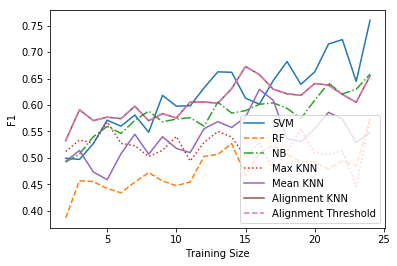

In [16]:
aucs = {}
for label in labels:
    aucs[label] = create_plots(label,statistics,names,metric_label="F1",outfile="results/tweets/f1_images/"+label+".png")

### Code to generate a latex style table

In [17]:
method_to_sort_by = "Alignment Threshold"
sort_inx = names.index(method_to_sort_by)
labels = []
F1_scores = []
for label, value in aucs.items():
    labels.append(label)
    F1_scores.append(-1.*aucs[label][sort_inx]["average"])

inxs = np.argsort(F1_scores)
labels = list(np.array(labels)[inxs])

first = True
num_winplus = 0
num_win = 0
num_tie = 0
num_lose = 0
for label in labels:
        if first:
            print("",end="")
            print(" & ",end="")
            print("Category",end="")
            print(" & ",end="")
            print("\# Samples",end="")
            for i in range(len(names)):
                print(" & ",end="")
                print(names[i],end="")
            print(" \\\\ \hline")
            first = False

        plabel = label.replace("_"," ")
        plabel = plabel.replace("NeighborhoodArea ","")
        plabel = plabel.replace("Interior ","")
        plabel = plabel.replace("PropertyLot ","")
        plabel = plabel.replace("Community ","")
        line = plabel
        #print(plabel,end="")
        line += " & "
        line += str(len(statistics[0][label].keys()))
        highest_other = 0
        lower_other = 1.0
        lower_for_method = None
        highest_for_method = None
        for i in range(len(names)):
            lower = np.round(100*aucs[label][i]["lower"])/100
            upper = np.round(100*aucs[label][i]["upper"])/100
            if i == sort_inx:
                lower_for_method = lower
                highest_for_method = upper
            else:
                if upper > highest_other:
                    highest_other = upper
                    lower_other = lower
            line += " & "
            line += str(lower)+" - "+str(upper)
        line += "\\\\"
        if lower_for_method > highest_other:
            line = "W+" + " & " + line
            num_winplus += 1
        elif lower_for_method > lower_other:
            line = "W" + " & " + line
            num_win += 1
        elif highest_for_method > lower_other:
            line = "T" + " & " + line
            num_tie += 1
        else:
            line = "L" + " & " + line
            num_lose += 1
        print(line)

 & Category & \# Samples & SVM & RF & NB & Max KNN & Mean KNN & Alignment KNN & Alignment Threshold \\ \hline
T & tweets & 23 & 0.53 - 0.61 & 0.39 - 0.48 & 0.49 - 0.58 & 0.43 - 0.52 & 0.45 - 0.54 & 0.52 - 0.6 & 0.52 - 0.6\\


In [18]:
print('Percent W+:',num_winplus*1.0/len(labels))

Percent W+: 0.0


In [19]:
print('Percent W+:',round(100*num_winplus*1.0/len(labels))/100)
print('Percent W:',round(100*num_win*1.0/len(labels))/100)
print('Percent T:',round(100*num_tie*1.0/len(labels))/100)
print('Percent L:',round(100*num_lose*1.0/len(labels))/100)

Percent W+: 0.0
Percent W: 0.0
Percent T: 1.0
Percent L: 0.0
